# Libraries

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [12]:
"""Load DataFrame"""
#df=pd.read_csv('vehicles.csv')
df=pd.read_csv('C:/Users/dell/Desktop/UsedCars/train.csv')
df=pd.DataFrame(df)
df.head()

,Unnamed: 0,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
0,121610,7309831550,2007.0,infiniti,m45,excellent,NaN,gas,214740.0,clean,automatic,rwd,NaN,sedan,black,ga,34.139588,-83.971135,2021-04-20T11:46:13-0400,7995
1,395646,7317007429,2008.0,cadillac,escalade,NaN,NaN,gas,170276.0,clean,automatic,NaN,NaN,SUV,black,wa,47.756950,-122.212230,2021-05-04T16:16:32-0700,14999
2,236366,7309202024,2003.0,lexus,es,NaN,NaN,gas,176910.0,clean,automatic,fwd,NaN,sedan,NaN,nc,34.209703,-77.843995,2021-04-19T10:07:58-0400,5995
3,66001,7306341714,2017.0,bmw,320i,excellent,NaN,gas,41000.0,clean,automatic,4wd,NaN,SUV,NaN,ca,33.811000,-117.849300,2021-04-13T13:05:06-0700,0
4,320855,7307880118,2008.0,toyota,rav4,good,6 cylinders,gas,138900.0,clean,automatic,4wd,full-size,SUV,silver,pa,40.143550,-76.597071,2021-04-16T15:22:02-0400,7995


In [19]:
'''"""Reindexing DataFrame so that price feature will at last"""
df= df.reindex(columns=['id', 'url', 'region', 'region_url', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long','price'])'''

'"""Reindexing DataFrame so that price feature will at last"""\ndf= df.reindex(columns=[\'id\', \'url\', \'region\', \'region_url\', \'year\', \'manufacturer\',\n       \'model\', \'condition\', \'cylinders\', \'fuel\', \'odometer\', \'title_status\',\n       \'transmission\', \'vin\', \'drive\', \'size\', \'type\', \'paint_color\',\n       \'image_url\', \'description\', \'county\', \'state\', \'lat\', \'long\',\'price\'])'

# 1) Removed Irrelevant features

In [20]:
df2=df.copy()
df2=df2.drop(columns=['state'])
df2.head()

,id,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,...,drive,size,type,paint_color,image_url,description,county,lat,long,price
0,7309831550,NaN,NaN,NaN,2007.0,infiniti,m45,excellent,NaN,gas,...,rwd,NaN,sedan,black,NaN,NaN,NaN,34.139588,-83.971135,7995
1,7317007429,NaN,NaN,NaN,2008.0,cadillac,escalade,NaN,NaN,gas,...,NaN,NaN,SUV,black,NaN,NaN,NaN,47.756950,-122.212230,14999
2,7309202024,NaN,NaN,NaN,2003.0,lexus,es,NaN,NaN,gas,...,fwd,NaN,sedan,NaN,NaN,NaN,NaN,34.209703,-77.843995,5995
3,7306341714,NaN,NaN,NaN,2017.0,bmw,320i,excellent,NaN,gas,...,4wd,NaN,SUV,NaN,NaN,NaN,NaN,33.811000,-117.849300,0
4,7307880118,NaN,NaN,NaN,2008.0,toyota,rav4,good,6 cylinders,gas,...,4wd,full-size,SUV,silver,NaN,NaN,NaN,40.143550,-76.597071,7995


# 2) Dealing with missing values

In [21]:
df2.isnull().sum() #return series of columns with respective of number of null values

id                   0
url             290129
region          290129
region_url      290129
year                 0
manufacturer     11342
model                0
condition       116104
cylinders       119300
fuel              1453
odometer             0
title_status      5066
transmission         0
vin             290129
drive            88087
size            207684
type             62596
paint_color      87113
image_url       290129
description     290129
county          290129
lat               4403
long              4403
price                0
dtype: int64

<Axes: >

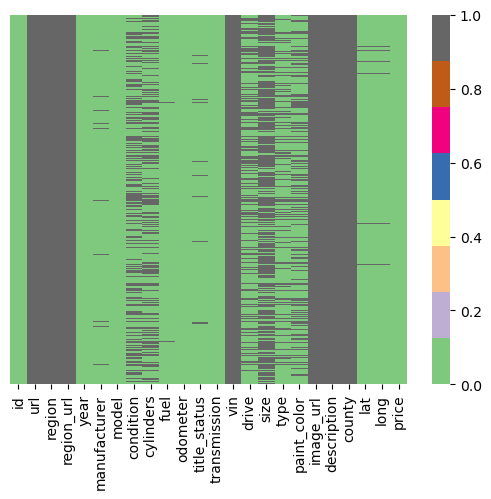

In [17]:
#heatmap to identify nulll values using graph
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [18]:
#define numeric variable and categorical variable to work separatly on them
num_col=['year','odometer','lat','long']
cat_cols=['manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color','posting_date']

# 2.1) Estimating better iterative imputer method

In [4]:
check_imputer=df2.copy()
check_imputer=check_imputer.drop(columns=['id'])

#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

NameError: name 'df2' is not defined

In [5]:
check_imputer.head()

NameError: name 'check_imputer' is not defined

In [6]:
"""metrics which measure the distance between the model
and the data, like metrics. mean_squared_error ,
are available as neg_mean_squared_error
which return the negated value of the metric."""


'metrics which measure the distance between the model\nand the data, like metrics. mean_squared_error ,\nare available as neg_mean_squared_error\nwhich return the negated value of the metric.'

In [11]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [ ]:
# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


In [ ]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer],
    keys=['SimpleImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

## 2.2) Filling Numerical Missing Values i.e year & odometer

In [ ]:
df2.isnull().sum()[num_col]

In [ ]:
data_num=df2[num_col]
imputer_num=IterativeImputer(estimators[2]) #estimators[2] = ExtraTreesRegressor
impute_data=imputer_num.fit_transform(data_num)
df2[num_col]=impute_data

In [ ]:
#Missing values after filling
df2.isnull().sum()[num_col]

## 2.4) Filling Categorical values

In [ ]:
#Missing values before filling
df2.isnull().sum()[cat_cols]

In [ ]:
data_cat=df2[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
df2[cat_cols]=data_cat    

In [ ]:
#Missing values after filling
df2.isnull().sum()[cat_cols]

In [ ]:
#Heat map tp check numm values visually
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [ ]:
#No null value in the dataset 
df2.isnull().sum()

In [ ]:
df2.to_csv('vehiclesData.csv',index=False)

In [ ]:
df2=pd.read_csv('vehiclesData.csv')

# 3) Outliers

In [ ]:
from IPython.display import display,Latex
outliers_condi=Latex(r" $\textbf{W𝑒 𝑐𝑎𝑛 𝑠𝑎𝑦 $𝑥_1$ or $x_2$ 𝑖𝑠 𝑜𝑢𝑡𝑙𝑖𝑒𝑟𝑠 if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")
outliers_info=Latex(r"$L_{p} = \frac{p}{100}(n+1) = i_p.f_p \\ where \,\, i_p \,\, is \,\, integer \,\, part \,\, of \,\, L_p \,\, and \,\, f_p \,\, is \,\, fractional \,\, part \,\, of \,\, L_p \\ Q1 = Y_{25} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ Q3 = Y_{75} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ IQR = Q3-Q1 \\ x_1 = Q1 - 1.5*IQR \,\,and\,\, x_2 = Q3+1.5*IQR $")

In [ ]:
display(outliers_info)
display(outliers_condi)

In [ ]:
#it will return the range of the variables and the values outside this range will be outliers
def outliers(arr,col):
    x=sorted(arr[col].values.ravel())
    L_25=25/100*(len(x)+1) #L_p where p=25%
    i_p=int(str(L_25).split(".")[0])
    f_p=int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75=75/100*(len(x)+1) #L_p where p=75%
    i_p=int(str(L_75).split(".")[0])
    f_p=int(str(L_75).split(".")[1])
    q3=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    #q1,q3=(arr[col].quantile([0.25,0.75]))
    
    IQR=q3-q1
    x1=q1-1.5*IQR
    x2=q3+1.5*IQR
    return (x1,x2)

## 3.1) Price

In [ ]:
def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)
df2['logprice'] = np.log(df2['price'])
x=df2['logprice']
price_range=list(range(0,int(max(df2['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(df2)[0]-0.3,1.05,str(round(min_max_price(df2)[0],2)))
plt.text(min_max_price(df2)[1]-0.5,1.05,str(round(min_max_price(df2)[1],2)))
plt.title("Figure 1: Box Plot of Price")
plt.savefig('graph-boxplot-price.jpg')
plt.show()

## 3.2) Odometer

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_title('Figure 2: Box Plot of Odometer')
ax1.boxplot(df2['odometer'], vert=False, flierprops=red_square)
plt.savefig('graph-boxplot-odometer.jpg')
plt.show()

## 3.3) Year

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#ploting boxplot
o1,o2=outliers(df2,'year')
ax1.boxplot(sorted(df2['year']), vert=False, flierprops=red_square)
ax1.set_xlabel("Years")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(df2['year'])
n, bins, patches = ax2.hist(x=df2['year'], bins=bins)
ax2.set_xlabel("Years")
ax2.set_title("Figure 4: Histogram of Year")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-year.jpg',dpi=1200)
plt.show()

In [ ]:
#removing outliers 
df_new=df2.copy()
out=np.array(['logprice','odometer','year'])
for col in out:
    o1,o2=outliers(df_new,col)
    df_new=df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new=df_new[df_new['price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

In [ ]:
df_new.head()

In [ ]:
print("Shape before process=",df.shape)
print("Shape After process=",df_new.shape)
diff=df.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,df.shape[1]-df_new.shape[1]))
df_new.to_csv("vehiclesFinal.csv",index=False)